# PID Temperature Controller
Implemented in VHDL for Basys-3 FPGA using Vivado. 

Implementation details:
* 4bit target mapped to switches on board.
* Fixed-point arithmetic in Q8.8, manual implementation, not using fixed_pkg.
* 1 KHz operation. 
* The plant is assumed to be a heat sink, like a water tank. A heat loss mechanism proportional to the difference to ambient remp is assumed.  

```mermaid
graph LR
    %% --- Define all nodes first ---
    N_Target["target<br> (4bit)"]
    %% Using Sigma for the summing junction N_SumError
    N_SumError((Σ))
    N_P["pid_pterm.vhd (Kp)"]
    N_I["pid_iterm.vhd (Ki)"]
    N_D["pid_dterm.vhd (Kd)"]
    %% Using Sigma for the summing junction N_SumPID
    N_SumPID((Σ))
    %% Matched Plant node text to your screenshot
    N_Plant["plant2.vhd"]

    %% --- Define links between nodes ---
    N_Target --(+)--> N_SumError
    N_SumError --error_calc.vhd--> N_P
    N_SumError --error_calc.vhd--> N_I
    N_SumError --error_calc.vhd--> N_D

    N_P --> N_SumPID
    N_I --> N_SumPID
    N_D --> N_SumPID

    N_SumPID --control_in--> N_Plant
    N_Plant --(-)--> N_SumError
```

## Phase 1: P-only microcontroller. 
We develop all the code to run a p-only controller. Signals are exposed at the top level to export signals to csv, plotted below.

Set target to "0100" (4 in decimal). Kp = 0.125

On the plot below, see the most obvious problem with a p-only controller -- a large steady-state error, in this case resulting from the built-in cooling rate in the plant.

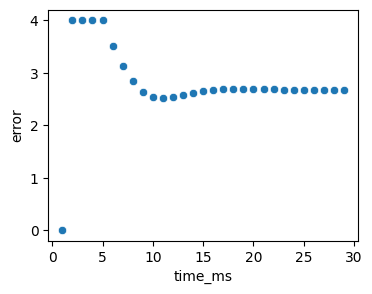

In [53]:
import importlib, polars as pl, dataplotter
importlib.reload(dataplotter) # dataplotter is a separate script I wrote to make the plots.  
import seaborn as sns
import matplotlib.pyplot as plt
# Preprocess the data
df = pl.read_csv(r'C:\prog\repos\PID_temperature_controller\data\sim_data_current.csv')
dfp = df.with_columns(((pl.col('Time')*1e-9)*1e3).alias('time_ms')).filter( pl.col('time_ms')>1)

fig, ax = plt.subplots(figsize=(4, 3))
_ = sns.scatterplot(dfp.filter( pl.col('time_ms')<30 ),x='time_ms',y='error',ax=ax)

## Phase 2: PI controller 
We add an integral term to study the change to the system. 
* Ki = 32/256 = 0.125

As shown below we see a substantial improvement. However the system a large oscillation. 

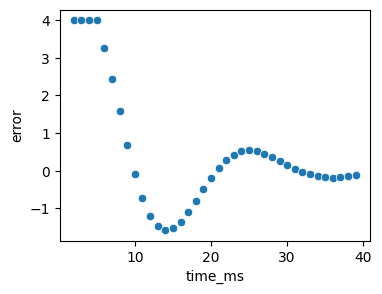

In [52]:
import importlib, polars as pl, dataplotter
importlib.reload(dataplotter) # dataplotter is a separate script I wrote to make the plots.  
import seaborn as sns
import matplotlib.pyplot as plt
# Preprocess the data
df = pl.read_csv(r'C:\prog\repos\PID_temperature_controller\data\sim_data_current_PI.csv')
dfp = df.with_columns(((pl.col('Time')*1e-9)*1e3).alias('time_ms')).filter( pl.col('time_ms')>2)

fig, ax = plt.subplots(figsize=(4, 3))
_ = sns.scatterplot(dfp.filter( pl.col('time_ms')<40 ),x='time_ms',y='error',ax=ax)